Text(0, 0.5, 'Cases - sqrt normalized')

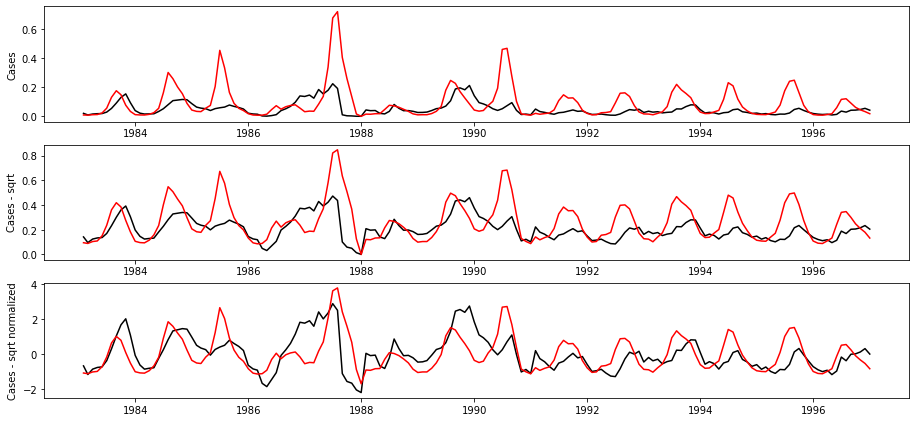

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data_dengue         = pd.read_csv('Dengue_Thailand.csv', sep=';')
data_dengue["date"] = pd.date_range(start='1983', end='1997', freq='1M')


fig, ax = plt.subplots(3, 1, figsize=(15.5, 7.2))

ax[0].plot(data_dengue.date, data_dengue.bang, color='k')
ax[0].plot(data_dengue.date, data_dengue.thai, color='r')
ax[0].set_ylabel('Cases')


data_dengue["bang_sqrt"] = np.sqrt(data_dengue["bang"])
data_dengue["thai_sqrt"] = np.sqrt(data_dengue["thai"])

ax[1].plot(data_dengue.date, data_dengue.bang_sqrt, color='k')
ax[1].plot(data_dengue.date, data_dengue.thai_sqrt, color='r')
ax[1].set_ylabel('Cases - sqrt')


data_dengue["bang_sqrt_norm"] = (data_dengue["bang_sqrt"]-data_dengue["bang_sqrt"].mean()) / data_dengue["bang_sqrt"].std()
data_dengue["thai_sqrt_norm"] = (data_dengue["thai_sqrt"]-data_dengue["thai_sqrt"].mean()) / data_dengue["thai_sqrt"].std()

ax[2].plot(data_dengue.date, data_dengue.bang_sqrt_norm, color='k')
ax[2].plot(data_dengue.date, data_dengue.thai_sqrt_norm, color='r')
ax[2].set_ylabel('Cases - sqrt normalized')



In [137]:
import numpy as np
# [wave,power,period,scale,coi] = WaveletTransform(y,dt,dj,lowerPeriod,upperPeriod,pad)

def WaveletTransform(y, dt, dj, lowerPeriod, upperPeriod, pad):
    ''' Morlet Wavelet transform of signal y.
        Decomposition between two periods [lowerPeriod ,upperPeriod]

        ------ input ------
        y           : Input Signal 
        dt          : Sampling Rate
        dj          : Freq. Resolution (i.e. number of sub-octaves)
        lowerPeriod : Lower Period of the decomposition
        upperPeriod : Upper Period of the decomposition
        pad         : In case of zero padding (it must be a power of two)
    
        ------ return ------
        wave      : wavelet Transform-matrix
        power     : power wavelet spectrum
        period    : the vector of "Fourier" periods (in time units)
                  : that corresponds to the scale.s
        scale     : the vector of scale indices, given by so*2.^((0:j1)*dj), j=0...J1
                    where J1 is the total number of scales.
        coi       : the "cone-of-influence", which is a vector of n_y points
                    that contains the limit of the region where the wavelet transform
                    is influenced by edge effects.
    '''

    ko = 6;
    fourier_factor = (4*np.pi)/(ko + np.sqrt(2+ko^2));

    so = lowerPeriod/fourier_factor;

    if (lowerPeriod == -1):
        so = 2*dt 

    if (dj == -1):
        dj = 1./4

    n1 = len(y);
    x  = y;

    coi = fourier_factor;
    coi = coi * dt * np.concatenate(( [1e-5],np.arange(1,((n1+1)/2-1)+1), np.flip( np.arange(1,(n1/2-1)+1)), [1e-5]))

    if (pad == 0):
        base2 = np.fix(np.log(n1)/np.log(2)+0.49999); # power of 2 nearest to N
        x     = np.zeros( (x, np.zeros((1,2**(base2+1)-n1)) ) );
        pad   = len(x);

    if pad > 0:
        base2 = np.log(pad) / np.log(2);
        x = np.concatenate( (x, np.zeros((int(2**(base2))-n1)) ));

    # new data length after zero padding
    n = len(x);  

    # Upper Period = max Number of Scales
    maxPeriod = n*dt;     # maximum Period allowed = T total
    numberofScales = np.fix((np.log(upperPeriod/fourier_factor/so)/np.log(2))/dj);
    j1 = numberofScales
    # If upperPeriod is too long
    largestNumberofScales = np.fix((np.log(n*dt / so) / np.log(2)) / dj);
    if (j1 == -1):
        j1 = largestNumberofScales # compute of the # scales

    if j1 > largestNumberofScales:
        RaiseError('upperPeriod is too long, it will be adapted')
        j1 = largestNumberofScales


    k = np.arange(1, np.fix(n/2)+1);
    k = k*((2.*np.pi)/(n*dt));
    k = np.concatenate( ([0], k, -np.flip(k[:-1]) ) );
    f = np.fft.fft( x )

    scale = so*2**((np.arange(0, j1+1))*dj);
    Num_scales = int(j1);
    wave    = np.zeros( (Num_scales+1, n) );
    wave    = wave + 1j*wave;
    ventana = len(k);

    for a1 in range(0,Num_scales+1):
        scal  = scale[a1];
        expnt = -(scal*k-ko)**2 / 2*(k > 0.);
        norm  = np.sqrt(scal*k[1])*(np.pi**(-0.25))*np.sqrt(ventana);
        daughter   = norm*np.exp(expnt);
        daughter   = daughter*(k > 0.);
        wave[a1,:] = np.fft.ifft(f*daughter);


    period = fourier_factor*scale;
    wave   = wave[:, :n1];                 # wavelet transform
    power  = (abs(wave))**2 ;      
    
    return wave, power, period, scale,coi

In [180]:
import math
def WaveletOutput(wave,power,period,scale,y,variance,dt,dj,lowPF,upPF):
    
    n = len(y);
    del_ = 0.776;
    avg = find((scale >= lowPF) & (scale < upPF));

    realwav = np.real(wave) ;                # Real part of the wavelet
    imagwav = np.imag(wave) ;                # Imaginary part of the wavelet

    global_ws = variance*(sum(power.T)/n); # Global wavelet spectrum
                                           # ie time-average over all times

    filtr_ts = np.repeat(np.expand_dims(np.sqrt(scale),-1), axis=1, repeats=n) ;   # Filtered time series
    filtr_ts = realwav / filtr_ts;       # based on periods between lowPF--upPF
    filtr_ts = np.pi**(1/4)*dj*np.sqrt(dt) / del_ * np.sum(filtr_ts[avg,:]); 

    filtr_var =  np.repeat(np.expand_dims( scale,-1), axis=1, repeats=n);       # Filtered variance of the time series
    filtr_var = power / filtr_var;       # based on periods between lowPF--upPF
    filtr_var = variance * dj * dt / del_ * np.sum(filtr_var[avg,:]); 
    phase_ts = np.arctan2(imagwav,realwav); # Phase of the time series
    phase_ts = np.mean(phase_ts[avg,:]);     # based on periods between lowPF--upPF

    
    return realwav, imagwav, global_ws, filtr_ts, filtr_var, phase_ts



In [195]:
def WaveletRidge(m, nb=2, amp=0):
    '''
      Calculation of the maxima of the matrice m, 
      these maxima are named RIDGE in the context of Wavelet Analysis
      a test has been introduce to plot just the value > amp*max
    
       rp = WaveletRidge(m,nb,amp)
    
    ----- INPUTS
     m    : the matrice for which one has to compute the ridges
     nb   : number of point used to compute a maximum, in fact 2*nb+1 points are used
     amp  : proportion of maximum value than one needs for plotting
    
    ----- OUTPUT
     rg   : ridge values approximated by the maximum of the matrice m

  
    '''

    if nb == 0:
        nb = 2

    s  = m.shape;
    nl = s[0];
    nc = s[1];
    rg = np.zeros(s);
    mm = amp*np.max(m[:]);

    for j in range(nc):
        for i in range(nb,nl-nb+1):
            if np.max(m[i-nb:i+nb,j]) == m[i,j] and m[i,j] > mm: 
                rg[i,j] = 1;

        for i in range(nb+1):
            if np.max(m[:i+nb,j]) == m[i,j] and m[i,j] > mm:
                rg[i,j] = 1
       
        for i in range(nl-nb,nl):
            if np.max(m[i-nb:nl,j]) == m[i,j] and m[i,j] > mm:
                rg[i,j] = 1;

    return rg



/Users/chaosdonkey06/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Cases')

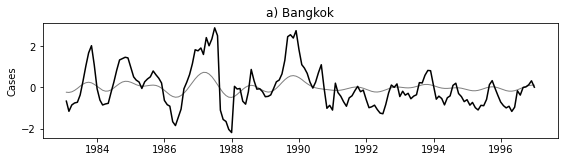

In [208]:
# wavelets parameters
dt = 1/12; dj = 1/30; pad = 256; stype = 1; wtype = 5; par = 0;
lowerPeriod=0.8; upperPeriod=7;
lowerPF = 2; upperPF = 3;
#rand('seed',1997); nh = 20; dh = (-pi:pi/nh:pi);
testx = 1; test = 1; ns = 200; pvalue = 5; nbb = 1; ps = 1; psx = 1; psy = 1; amp = 10; 
#Yticks = [1 2 3 4 6 8]; cor = 100; ipp = 0.5;

x = data_dengue["bang_sqrt_norm"].values;   # Bangkok
N = len(dat_norm)
t = data_dengue.date

# wavelets trasfrorm and associated statistical test
wave, power, period, scale, coi = WaveletTransform(x, dt, dj, lowerPeriod, upperPeriod, pad);


# 
n_x = len(x); m_x = np.mean(x); var_x = np.std(x)**2;
realwav,imagwav,global_ws,filtr_ts,filtr_var,phase_t1 = WaveletOutput(wave,power,period,scale,x,var_x,dt,dj,lowerPF,upperPF);

rid = WaveletRidge(power,3,.14);



# Prepare the figure
pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t,  , '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, x, 'k', linewidth=1.5)
ax.set_title('a) Bangkok')
ax.set_ylabel(r'Cases')




# Bang

/Users/chaosdonkey06/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


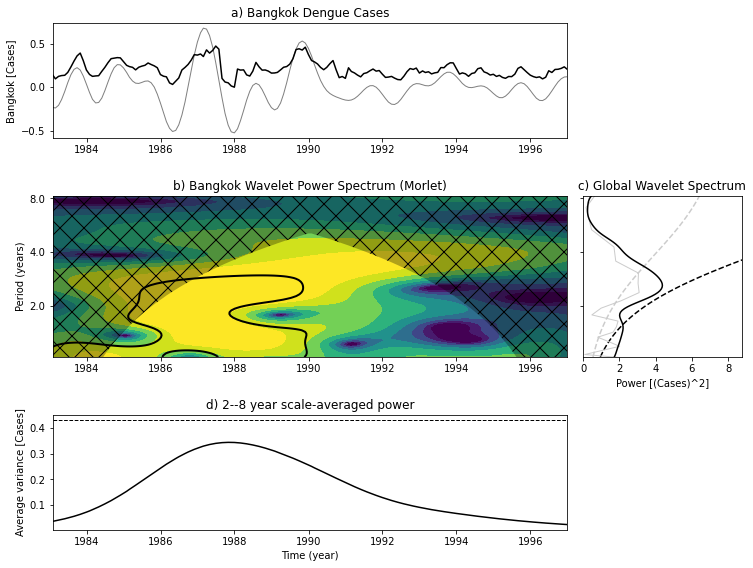

In [255]:
import datetime


dt = 1/12; dj = 1/30; pad = 256; stype = 1; wtype = 6; par = 0;


dat= data_dengue["bang_sqrt"].values;

mother = wavelet.Morlet(6)
s0 = 1  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 30  # Twelve sub-octaves per octaves
J = 3 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

dat_norm = data_dengue["bang_sqrt_norm"].values;   # Bangkok

# The following routines perform the wavelet transform and inverse wavelet
# transform using the parameters defined above. Since we have normalized our
# input time-series, we multiply the inverse transform by the standard
# deviation.
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

# We calculate the normalized wavelet and Fourier power spectra, as well as
# the Fourier equivalent periods for each wavelet scale.
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs

# We could stop at this point and plot our results. However we are also
# interested in the power spectra significance test. The power is significant
# where the ratio ``power / sig95 > 1``.
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)

N = len(data_dengue)
t = data_dengue.date

sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95

# Then, we calculate the global wavelet spectrum and determine its
# significance level.
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

# We also calculate the scale average between 2 years and 8 years, and its
# significance level.
sel = find((period >= 2) & (period < 8))
Cdelta = mother.cdelta
scale_avg = (scales * numpy.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

title = 'Bangkok Dengue Cases'
label= 'Bangkok'
units= 'Cases'

# Prepare the figure
pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)

t = data_dengue.date
dt_date = datetime.timedelta(weeks=4)
bx.fill(numpy.concatenate([t, t[-1:] + dt_date, t[-1:] + dt_date,
                           t[:1] - dt_date, t[:1] - dt_date]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, numpy.log2(period), 'k--')
cx.plot(var * fft_theor, numpy.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
        linewidth=1.)
cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, glbl_power.max() + var])
cx.set_ylim(numpy.log2([period.min(), period.max()]))
cx.set_yticks(numpy.log2(Yticks))
cx.set_yticklabels(Yticks)
pyplot.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = pyplot.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
dx.set_title('d) {}--{} year scale-averaged power'.format(2, 8))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

pyplot.show()

# Rest of thailand

/Users/chaosdonkey06/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


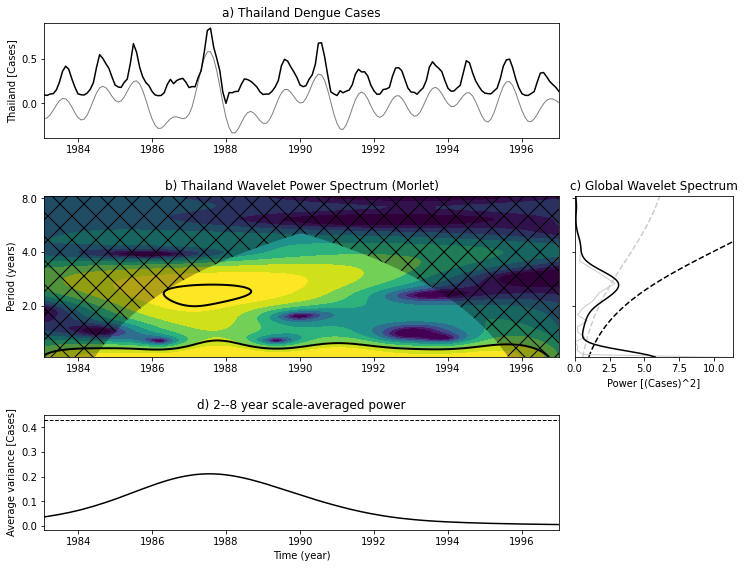

In [256]:
import datetime



dt = 1/12; dj = 1/30; pad = 256; stype = 1; wtype = 6; par = 0;


dat= data_dengue["thai_sqrt"].values;

mother = wavelet.Morlet(6)
s0 = stype  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 30  # Twelve sub-octaves per octaves
J = 3 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise



dat_norm = data_dengue["thai_sqrt_norm"].values;   # Bangkok

# The following routines perform the wavelet transform and inverse wavelet
# transform using the parameters defined above. Since we have normalized our
# input time-series, we multiply the inverse transform by the standard
# deviation.
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

# We calculate the normalized wavelet and Fourier power spectra, as well as
# the Fourier equivalent periods for each wavelet scale.
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs

# We could stop at this point and plot our results. However we are also
# interested in the power spectra significance test. The power is significant
# where the ratio ``power / sig95 > 1``.
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)

N = len(data_dengue)
t = data_dengue.date

sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95

# Then, we calculate the global wavelet spectrum and determine its
# significance level.
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

# We also calculate the scale average between 2 years and 8 years, and its
# significance level.
sel = find((period >= 2) & (period < 8))
Cdelta = mother.cdelta
scale_avg = (scales * numpy.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

title = 'Thailand Dengue Cases'
label= 'Thailand'
units= 'Cases'

# Prepare the figure
pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)

t = data_dengue.date
dt_date = datetime.timedelta(weeks=4)
bx.fill(numpy.concatenate([t, t[-1:] + dt_date, t[-1:] + dt_date,
                           t[:1] - dt_date, t[:1] - dt_date]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, numpy.log2(period), 'k--')
cx.plot(var * fft_theor, numpy.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
        linewidth=1.)
cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, glbl_power.max() + var])
cx.set_ylim(numpy.log2([period.min(), period.max()]))
cx.set_yticks(numpy.log2(Yticks))
cx.set_yticklabels(Yticks)
pyplot.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = pyplot.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
dx.set_title('d) {}--{} year scale-averaged power'.format(2, 8))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

pyplot.show()